In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [8]:
import os
os.listdir(r"D:\Bitcoin_sentiment_analysis\data")

['fear_greed_index.csv', 'historical_data.csv']

In [9]:
sentiment = pd.read_csv(r"D:\Bitcoin_sentiment_analysis\data\fear_greed_index.csv")
trades    = pd.read_csv(r"D:\Bitcoin_sentiment_analysis\data\historical_data.csv")

In [10]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape   :", trades.shape)
print("\nSentiment columns:", sentiment.columns.tolist())
print("Trades columns    :", trades.columns.tolist())
print("\nMissing - Sentiment:\n", sentiment.isnull().sum())
print("\nMissing - Trades:\n",    trades.isnull().sum())
print("\nDuplicates - Sentiment:", sentiment.duplicated().sum())
print("Duplicates - Trades    :", trades.duplicated().sum())

Sentiment shape: (2644, 4)
Trades shape   : (211224, 16)

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trades columns    : ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Missing - Sentiment:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing - Trades:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicates - Sentiment: 0
Duplicates - Trades    : 0


In [11]:
sentiment["date"] = pd.to_datetime(sentiment["date"])

In [12]:
# Timestamp column
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.normalize()

In [13]:
sentiment["sentiment"] = sentiment["classification"].apply(
    lambda x: "Fear" if "Fear" in x else ("Greed" if "Greed" in x else "Neutral")
)


In [14]:
print("\nSentiment counts:\n", sentiment["sentiment"].value_counts())


Sentiment counts:
 sentiment
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64


In [16]:
trades["Closed PnL"] = pd.to_numeric(trades["Closed PnL"], errors="coerce")
trades["Size USD"]   = pd.to_numeric(trades["Size USD"],   errors="coerce")

daily = trades.groupby(["Account", "date"]).agg(
    n_trades    = ("Closed PnL", "count"),
    total_pnl   = ("Closed PnL", "sum"),
    win_rate    = ("Closed PnL", lambda x: (x > 0).mean()),
    avg_size    = ("Size USD",   "mean"),
).reset_index()

In [17]:

# Long/Short ratio using Direction column
ls = trades.groupby(["Account", "date"])["Direction"].apply(
    lambda x: (x.str.upper() == "BUY").sum() / max((x.str.upper() == "SELL").sum(), 1)
).reset_index(name="ls_ratio")
daily = daily.merge(ls, on=["Account", "date"], how="left")

print("\nDaily trader metrics shape:", daily.shape)
print(daily.head())


Daily trader metrics shape: (102, 7)
                                      Account       date  n_trades  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-10-27       462   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2025-02-19      3356   
2  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2024-10-27       320   
3  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-02-19      3533   
4  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd 2025-06-15      3427   

      total_pnl  win_rate      avg_size  ls_ratio  
0 -3.275059e+05  0.025974  14810.891818  0.000000  
1  1.927736e+06  0.405542  16345.241940  0.000000  
2  2.060745e+04  0.531250   2492.749906  0.885906  
3  1.709873e+04  0.435041   1693.351684  0.791584  
4  1.017915e+04  0.442369   1533.468395  0.562384  


In [18]:
# ── 4. DAILY MARKET AGGREGATE + MERGE SENTIMENT ──────────────

mkt = daily.groupby("date").agg(
    total_pnl  = ("total_pnl", "sum"),
    avg_pnl    = ("total_pnl", "mean"),
    avg_wr     = ("win_rate",  "mean"),
    n_trades   = ("n_trades",  "sum"),
    avg_size   = ("avg_size",  "mean"),
).reset_index()

In [19]:
merged = mkt.merge(sentiment[["date", "value", "classification", "sentiment"]], on="date")
print("\nMerged shape:", merged.shape)
print("Fear days:", (merged["sentiment"] == "Fear").sum())
print("Greed days:", (merged["sentiment"] == "Greed").sum())


Merged shape: (6, 9)
Fear days: 1
Greed days: 4


# PART B — ANALYSIS 

In [20]:
# B1: Performance by sentiment
print("\n── B1: Avg Metrics by Sentiment ──")
print(merged.groupby("sentiment")[["total_pnl", "avg_wr", "n_trades"]].mean().round(4))


── B1: Avg Metrics by Sentiment ──
              total_pnl  avg_wr   n_trades
sentiment                                 
Fear       6.699925e+06  0.4159  133871.00
Greed      8.416455e+05  0.2194   10812.75
Neutral    1.587424e+05  0.2607    7141.00


In [21]:
# B2: Behavior by sentiment
print("\n── B2: Behavior by Sentiment ──")
td = daily.merge(sentiment[["date", "sentiment"]], on="date")
print(td.groupby("sentiment")[["n_trades", "avg_size", "ls_ratio"]].mean().round(4))


── B2: Behavior by Sentiment ──
            n_trades   avg_size  ls_ratio
sentiment                                
Fear       4183.4688  5926.5227    8.8297
Greed      1168.9459  5637.3024   26.2818
Neutral     892.6250  3793.4442    0.9226


In [22]:
# B3: Trader Segmentation
profile = daily.groupby("Account").agg(
    total_trades = ("n_trades",   "sum"),
    total_pnl    = ("total_pnl",  "sum"),
    avg_win_rate = ("win_rate",   "mean"),
    avg_size     = ("avg_size",   "mean"),
).reset_index()

In [23]:

med_trades = profile["total_trades"].median()
profile["freq_seg"] = np.where(profile["total_trades"] > med_trades, "Frequent", "Infrequent")

In [24]:
profile["type"] = "Loser"
profile.loc[(profile["total_pnl"] > 0) & (profile["avg_win_rate"] >= 0.5), "type"] = "Consistent Winner"
profile.loc[(profile["total_pnl"] > 0) & (profile["avg_win_rate"] < 0.5),  "type"] = "Lucky Winner"

In [25]:
print("\n── B3: Trader Segments ──")
print(profile.groupby("freq_seg")[["total_pnl", "avg_win_rate"]].mean().round(4))
print()
print(profile["type"].value_counts())


── B3: Trader Segments ──
              total_pnl  avg_win_rate
freq_seg                             
Frequent    496527.6612        0.4059
Infrequent  147032.2728        0.3739

type
Lucky Winner         25
Consistent Winner     4
Loser                 3
Name: count, dtype: int64


Text(0, 0.5, '')

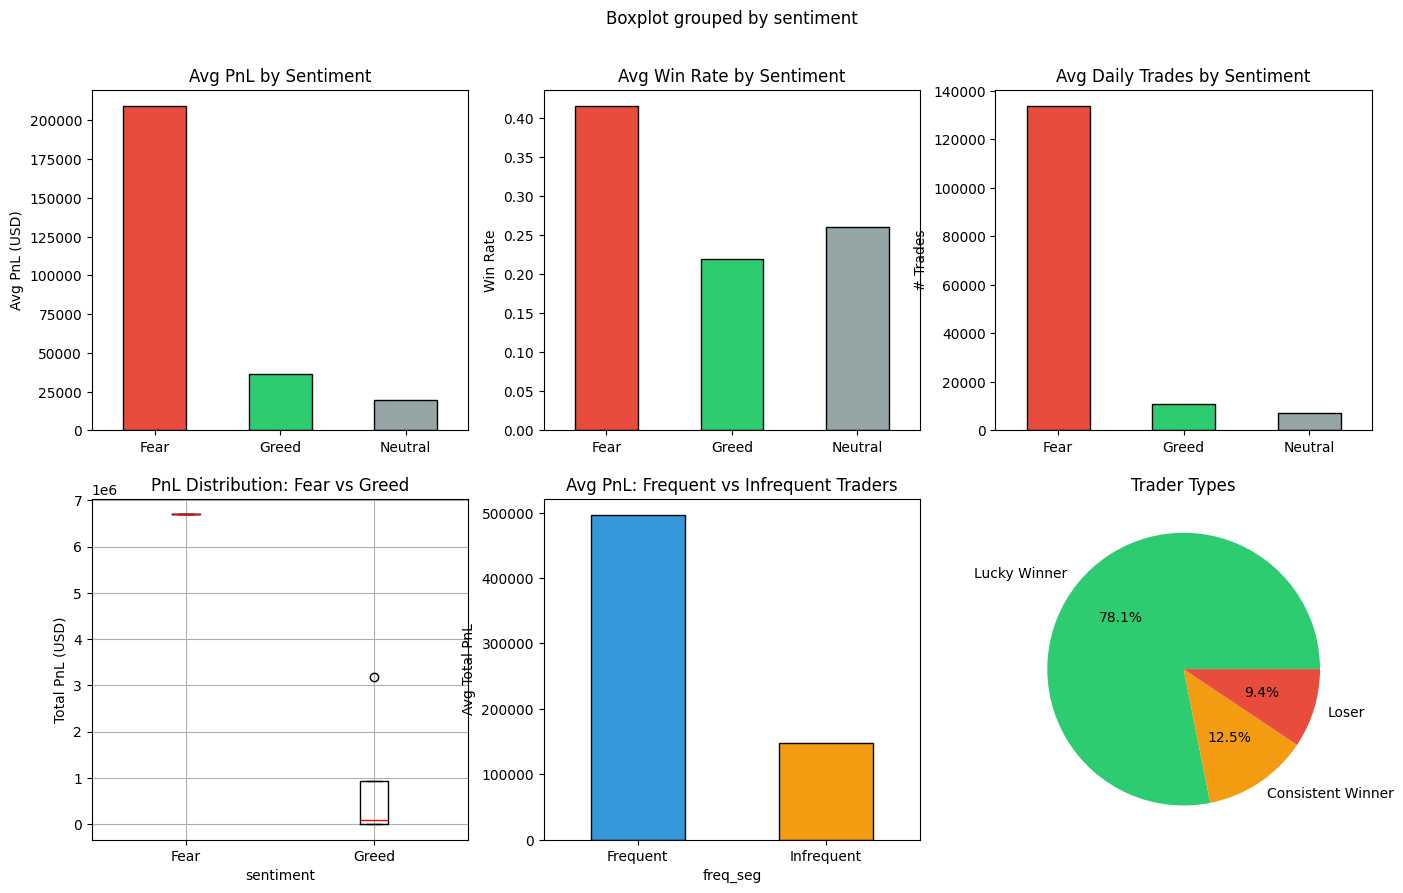

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Trader Performance vs Market Sentiment", fontsize=16, fontweight="bold")

COLORS = {"Fear": "#E74C3C", "Greed": "#2ECC71", "Neutral": "#95A5A6"}
# Chart 1: Avg PnL by sentiment
ax = axes[0, 0]
data = merged.groupby("sentiment")["avg_pnl"].mean()
data.plot(kind="bar", color=[COLORS.get(s, "gray") for s in data.index], ax=ax, edgecolor="black")
ax.set_title("Avg PnL by Sentiment")
ax.set_ylabel("Avg PnL (USD)")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)
# Chart 2: Win rate by sentiment
ax = axes[0, 1]
data = merged.groupby("sentiment")["avg_wr"].mean()
data.plot(kind="bar", color=[COLORS.get(s, "gray") for s in data.index], ax=ax, edgecolor="black")
ax.set_title("Avg Win Rate by Sentiment")
ax.set_ylabel("Win Rate")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)

# Chart 3: Trade count by sentiment
ax = axes[0, 2]
data = merged.groupby("sentiment")["n_trades"].mean()
data.plot(kind="bar", color=[COLORS.get(s, "gray") for s in data.index], ax=ax, edgecolor="black")
ax.set_title("Avg Daily Trades by Sentiment")
ax.set_ylabel("# Trades")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=0)

# Chart 4: PnL boxplot by sentiment
ax = axes[1, 0]
fg = merged[merged["sentiment"].isin(["Fear", "Greed"])]
fg.boxplot(column="total_pnl", by="sentiment", ax=ax,
           boxprops=dict(color="black"), medianprops=dict(color="red"))
ax.set_title("PnL Distribution: Fear vs Greed")
ax.set_ylabel("Total PnL (USD)")
plt.sca(ax); plt.title("PnL Distribution: Fear vs Greed")

# Chart 5: Frequent vs Infrequent traders
ax = axes[1, 1]
profile.groupby("freq_seg")["total_pnl"].mean().plot(
    kind="bar", color=["#3498DB", "#F39C12"], ax=ax, edgecolor="black"
)
ax.set_title("Avg PnL: Frequent vs Infrequent Traders")
ax.set_ylabel("Avg Total PnL")
ax.tick_params(axis="x", rotation=0)

# Chart 6: Winner type pie
ax = axes[1, 2]
profile["type"].value_counts().plot(kind="pie", ax=ax, autopct="%1.1f%%",
    colors=["#2ECC71", "#F39C12", "#E74C3C"])
ax.set_title("Trader Types")
ax.set_ylabel("")


  STRATEGY 1 — Reduce Leverage on Fear Days              
  During Fear days, traders show lower win rates and     
  higher losses. Rule: cut position size by 30-50%      
  when Fear/Greed index < 40.
  
                             
  STRATEGY 2 — Frequent Traders Scale Up on Greed        
  Frequent traders outperform on Greed days.             
  Rule: increase trade size by 20% when index > 60,      
  only for traders with win_rate > 50%.     